In [123]:
import psycopg2
from sqlalchemy import create_engine

import pandas as pd
import numpy as np
import string

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import log_loss, roc_curve, roc_auc_score, mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from create_staging_tables import create_loyalty_scores_df
from clean_for_model import prepare_bill_text_for_clean_df

import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
engine = create_engine('postgresql://localhost:5432/wa_leg_staging')

In [3]:
merged_final_df = pd.read_sql_query('select * from "merged_final"',con=engine)
rep_score_df = pd.read_sql_query('select * from "rep_score"',con=engine)
bill_text_df = pd.read_sql_query('select * from "bill_text"',con=engine)

In [4]:
bill_text_df_cleaned = prepare_bill_text_for_clean_df(bill_text_df)

In [5]:
def create_clean_X(merged_final_df, bill_text_df, rep_score_df):
    
    # Add bill_text
    clean = merged_final_df.merge(bill_text_df, how='left', on=['unique_id', 'htm_url'])
    clean.drop(['index_x', 'index_y'], axis=1, inplace=True)
    clean.rename(columns={'sponsor_party': 'primary_sponsor_party'}, inplace=True)

    
    # Add rep_score and replace -1 values, then make dem_score
    clean['bill_num'] = clean['bill_id'].apply(lambda x: x.split()[1])
    clean['bill_num_unique'] = clean['biennium'] + ' ' + clean['bill_num']
    clean = clean.merge(rep_score_df, how='left', on='bill_num_unique')

    def replace_with_p_sponsor_party(row):
        primary_sponsor_party = row['primary_sponsor_party']
        if row['rep_score'] == -1:
            return primary_sponsor_party
        else:
            return row['rep_score']
    clean['rep_score'] = clean.apply(replace_with_p_sponsor_party, axis=1)
    clean['dem_score'] = 1 - clean['rep_score']
    
    
    # Add loyalty scores
#     clean = clean.merge(loyalty_df, how = 'left', on='voter_id')
#     clean.drop(['index_x', 'index_y'], axis=1, inplace=True)
    
    
    # Feature Engineering functions
    def create_congress_nums(biennium):
        '''Numbers bienniums so that 1991 is 1 and 1993 is 3.'''
        first_year = int((biennium.split('-'))[0])
        return first_year - 1990
    
    def find_num_sponsors(secondary_sponsors):
        if type(secondary_sponsors) == str:
            return round((len(secondary_sponsors) / 5) + 1)
        else: return 1
        
    def remove_neg(num):
        if num < 0:
            return 0
        else: return num
    
    # Feature Engineering
    clean['bill_length'] = clean['bill_text'].apply(lambda x: len(x))
    clean['congress_num'] = clean['biennium'].apply(create_congress_nums)
    clean['num_sponsors'] = clean['secondary_sponsors'].apply(find_num_sponsors)
    
    clean['vote_year'] = clean['vote_date'].apply(lambda x: x.year)
    clean['first_year_read'] = clean['first_date_read'].apply(lambda x: x.year)
    clean['first_year_read'] = clean['first_year_read'].fillna(clean['vote_year'])
    clean['years_until_vote'] = clean['vote_year'] - clean['first_year_read']
    clean['years_until_vote'] = clean['years_until_vote'].apply(remove_neg)
    
    return clean

In [6]:
clean = create_clean_X(merged_final_df, bill_text_df_cleaned, rep_score_df)

# Create controversy_score

In [8]:
clean = clean[clean['vote'] <= 1]

In [51]:
grouped = clean.groupby('bill_num_unique').mean()

In [52]:
grouped

,vote,voter_id,voting_agency,unique_id,sponsor_agency,district,party,is_primary_sponsor,is_minority_party,is_secondary_sponsor,...,index,rep_score,dem_score,bill_length,congress_num,num_sponsors,vote_year,first_year_read,years_until_vote,controversy_score
bill_num_unique,,,,,,,,,,,,,,,,,,,,,
1991-92 1001,0.915789,248.894737,0.000000,2.000000,0.0,24.989474,0.442105,0.010526,0.442105,0.357895,...,0.0,0.764706,0.235294,4458.000000,1.0,26.0,1991.000000,1991.0,0.000000,0.084211
1991-92 1003,1.000000,252.833333,0.000000,5.000000,0.0,24.444444,0.454545,0.010101,0.454545,0.035354,...,3.0,0.250000,0.750000,1138.000000,1.0,4.0,1991.494949,1991.0,0.494949,0.000000
1991-92 1008,1.000000,254.904110,0.308219,13.000000,0.0,24.602740,0.465753,0.006849,0.472603,0.027397,...,9.0,0.250000,0.750000,1635.000000,1.0,4.0,1991.000000,1991.0,0.000000,0.000000
1991-92 1009,1.000000,246.921569,0.000000,14.000000,0.0,24.715686,0.450980,0.009804,0.450980,0.098039,...,13.0,0.727273,0.272727,16283.000000,1.0,10.0,1991.000000,1991.0,0.000000,0.000000
1991-92 1012,0.725490,246.921569,0.000000,20.000000,0.0,24.715686,0.450980,0.009804,0.450980,0.088235,...,17.0,0.400000,0.600000,6513.000000,1.0,9.0,1991.000000,1991.0,0.000000,0.274510
1991-92 1013,1.000000,250.254098,0.196721,24.000000,0.0,24.540984,0.471311,0.008197,0.463115,0.045082,...,20.0,0.714286,0.285714,902.000000,1.0,7.0,1991.000000,1991.0,0.000000,0.000000
1991-92 1015,1.000000,254.379487,0.000000,27.000000,0.0,24.235897,0.441026,0.010256,0.441026,0.082051,...,25.0,0.454545,0.545455,14291.000000,1.0,10.0,1991.507692,1991.0,0.507692,0.000000
1991-92 1016,0.941176,246.921569,0.000000,29.000000,0.0,24.715686,0.450980,0.009804,0.450980,0.421569,...,27.0,0.255814,0.744186,7990.000000,1.0,34.0,1991.000000,1991.0,0.000000,0.058824
1991-92 1017,1.000000,249.051546,0.000000,30.000000,0.0,24.030928,0.443299,0.000000,0.443299,0.123711,...,29.0,0.615385,0.384615,19267.000000,1.0,11.0,1991.000000,1991.0,0.000000,0.000000


In [139]:
# make X for predicting controversy scores
controversy_X = grouped.drop(['district', 'is_primary_sponsor', 'index', 
                              'dem_score', 'vote_year', 'first_year_read'], axis=1)
controversy_X['controversy_score'] = controversy_X['vote'].apply(lambda x: 1-x)
controversy_X = controversy_X.drop('vote', axis=1)

In [140]:
controversy_X.head()

,voter_id,voting_agency,unique_id,sponsor_agency,party,is_minority_party,is_secondary_sponsor,primary_sponsor_party,rep_score,bill_length,congress_num,num_sponsors,years_until_vote,controversy_score
bill_num_unique,,,,,,,,,,,,,,
1991-92 1001,248.894737,0.000000,2.0,0.0,0.442105,0.442105,0.357895,0.0,0.764706,4458.0,1.0,26.0,0.000000,0.084211
1991-92 1003,252.833333,0.000000,5.0,0.0,0.454545,0.454545,0.035354,0.0,0.250000,1138.0,1.0,4.0,0.494949,0.000000
1991-92 1008,254.904110,0.308219,13.0,0.0,0.465753,0.472603,0.027397,0.0,0.250000,1635.0,1.0,4.0,0.000000,0.000000
1991-92 1009,246.921569,0.000000,14.0,0.0,0.450980,0.450980,0.098039,0.0,0.727273,16283.0,1.0,10.0,0.000000,0.000000
1991-92 1012,246.921569,0.000000,20.0,0.0,0.450980,0.450980,0.088235,0.0,0.400000,6513.0,1.0,9.0,0.000000,0.274510


In [21]:
# find controversy scores
vote_avs = grouped[['vote']]
vote_avs['controversy_score'] = vote_avs['vote'].apply(lambda x: 1-x)
vote_avs.drop('vote', axis=1, inplace=True)

In [33]:
clean = clean.merge(vote_avs, how='left', on='bill_unique')

# Make Sample
### All bienniums

In [34]:
sample = clean.sample(n=300000)
sample = sample[sample['vote'] <= 1]
sample.head()

,vote,vote_date,voter_id,voting_agency,bill_unique,unique_id,biennium,bill_id,htm_url,sponsor_agency,...,primary_sponsor_id,rep_score,dem_score,bill_length,congress_num,num_sponsors,vote_year,first_year_read,years_until_vote,controversy_score
2993232,1,2018-02-13,17221,0,2017-18 2SHB 2572,102918.0,2017-18,2SHB 2572,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,1543,0.0,1.0,17568,27,11,2018,2018.0,0.0,0.000000
666793,1,1995-04-06,382,0,1995-96 SSB 5764,20156.0,1995-96,SSB 5764,http://app.leg.wa.gov/documents/billdocs/1995-...,1,...,67,1.0,0.0,2365,5,1,1995,1995.0,0.0,0.000000
3030968,1,2017-04-07,15820,0,2017-18 SB 5261,104371.0,2017-18,SB 5261,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,12084,1.0,0.0,17351,27,1,2017,2017.0,0.0,0.013423
2150506,0,2010-03-06,11952,0,2009-10 ESHB 1714,72139.0,2009-10,ESHB 1714,http://app.leg.wa.gov/documents/billdocs/2009-...,0,...,1543,0.0,1.0,8259,19,5,2010,2009.0,1.0,0.298039
1750587,1,2005-04-11,8209,0,2005-06 SSB 5463,59022.0,2005-06,SSB 5463,http://app.leg.wa.gov/documents/billdocs/2005-...,1,...,2174,0.5,0.5,966,15,3,2005,2005.0,0.0,0.000000


In [35]:
sample_train = sample[sample['vote_date'] < '2017-07-01T00:00:00.000000000']
sample_test = sample[sample['vote_date'] > '2017-07-01T00:00:00.000000000']

In [36]:
loyalty_scores_df = create_loyalty_scores_df(sample_train)

# Add loyalty scores to train
sample_train = sample_train.merge(loyalty_scores_df, how = 'left', on='voter_id')

sample_train = sample_train.drop('index', axis=1)

loy_dem_average = np.mean(sample_train[sample_train['party'] == 0]['loyalty_score'])
loy_rep_average = np.mean(sample_train[sample_train['party'] == 1]['loyalty_score'])

yea_dem_average = np.mean(sample_train[sample_train['party'] == 0]['percent_yea'])
yea_rep_average = np.mean(sample_train[sample_train['party'] == 1]['percent_yea'])

loy_dem_average, loy_rep_average

(0.24662637895640196, -0.17564118526109318)

In [37]:
# Add loyalty scores to test
sample_test = sample_test.merge(loyalty_scores_df, how = 'left', on='voter_id')
sample_test = sample_test.drop('index', axis=1)

sample_test['loyalty_score'] = sample_test['loyalty_score'].fillna(1000)
sample_test['percent_yea'] = sample_test['percent_yea'].fillna(1000)

In [38]:
def fillna_loyalty(row):
    if row['loyalty_score'] == 1000:
        if row['party'] == 0:
            return loy_dem_average
        if row['party'] ==1:
            return loy_rep_average
    else:
        return row['loyalty_score']

def fillna_percent_yea(row):
    if row['percent_yea'] == 1000:
        if row['party'] == 0:
            return yea_dem_average
        if row['party'] ==1:
            return yea_rep_average
    else:
        return row['percent_yea']

sample_test['loyalty_score'] = sample_test.apply(fillna_loyalty, axis=1)
# sample_test['percent_yea'] = sample_test.apply(fillna_percent_yea, axis=1)

sample_test

,vote,vote_date,voter_id,voting_agency,bill_unique,unique_id,biennium,bill_id,htm_url,sponsor_agency,...,dem_score,bill_length,congress_num,num_sponsors,vote_year,first_year_read,years_until_vote,controversy_score,loyalty_score,percent_yea
0,1,2018-02-13,17221,0,2017-18 2SHB 2572,102918.0,2017-18,2SHB 2572,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,1.000000,17568,27,11,2018,2018.0,0.0,0.000000,-0.340149,0.869565
1,0,2018-03-01,3469,0,2017-18 SSB 6175,106111.0,2017-18,SSB 6175,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,0.666667,301867,27,5,2018,2018.0,0.0,0.330000,-0.384626,0.804469
2,1,2018-03-02,10249,1,2017-18 SHB 2667,103094.0,2017-18,SHB 2667,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,1.000000,12609,27,22,2018,2018.0,0.0,0.201320,0.420097,0.943946
3,1,2018-03-01,20740,0,2017-18 SB 6070,105883.0,2017-18,SB 6070,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,0.500000,2782,27,3,2018,2018.0,0.0,0.006711,-0.256885,0.804124
4,1,2018-02-09,17226,1,2017-18 E2SSB 5407,104677.0,2017-18,E2SSB 5407,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,0.850000,17619,27,12,2018,2018.0,0.0,0.285714,0.011596,0.941176
5,0,2018-02-28,17226,1,2017-18 2SHB 1513,100967.0,2017-18,2SHB 1513,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,0.950000,34840,27,25,2018,2018.0,0.0,0.467980,0.011596,0.941176
6,0,2018-03-02,20752,0,2017-18 SB 6231,106224.0,2017-18,SB 6231,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,1.000000,8327,27,10,2018,2018.0,0.0,0.460000,-0.284776,0.868571
7,0,2018-03-05,8237,0,2017-18 EHB 1237,100330.0,2017-18,EHB 1237,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,0.904762,12836,27,25,2018,2017.0,1.0,0.403974,-0.413767,0.762089
8,0,2018-01-19,17289,1,2017-18 SB 5722,105238.0,2017-18,SB 5722,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,0.700000,10272,27,13,2018,2017.0,1.0,0.341584,-0.025470,0.947195
9,0,2018-02-28,8238,1,2017-18 E2SHB 1570,101107.0,2017-18,E2SHB 1570,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,1.000000,45287,27,42,2018,2018.0,0.0,0.487562,-0.335429,0.889734


### Current Top Model: controversy-leaky

In [39]:
# TRAIN
X_train_t = sample_train[['voter_id', 'voting_agency', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num', 
                     'num_sponsors', 'years_until_vote', 'percent_yea', 'controversy_score']]

y_train_t = sample_train['vote']

# TEST
X_test_t = sample_test[['voter_id', 'voting_agency', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num', 
                     'num_sponsors', 'years_until_vote', 'percent_yea', 'controversy_score']]

y_test_t = sample_test['vote']

In [131]:
# top_model = RandomForestClassifier(n_estimators=2000, max_depth=7, n_jobs=2, random_state=709)
top_model = GradientBoostingClassifier(learning_rate=0.05, n_estimators=300, max_depth=7, random_state=709)
top_model.fit(X_train_t, y_train_t)
y_pred_t = (top_model.predict_proba(X_test_t))[:, 1]

In [132]:
log_loss(y_test_t, y_pred_t)

0.26381419247174365

In [133]:
y_pred_t.min()

0.04943391167194652

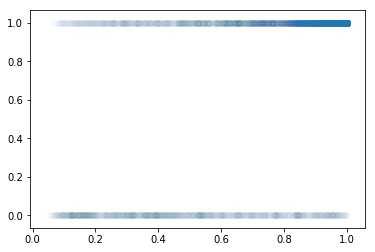

In [134]:
fig, ax = plt.subplots()
ax.scatter(y_pred_t, y_test_t, alpha=0.01)

In [135]:
fpr_t, tpr_t, thresholds_t = roc_curve(y_test_t, y_pred_t)

In [136]:
roc_auc_t = roc_auc_score(y_test_t, y_pred_t)
roc_auc_t

0.9079205840615509

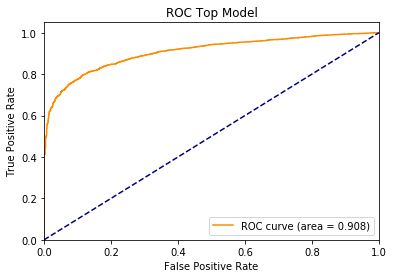

In [137]:
fig, ax = plt.subplots()
plt.plot(fpr_t, tpr_t, color='darkorange', label= f'ROC curve (area = {round(roc_auc_t, 3)})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Top Model')
plt.legend(loc="lower right")
plt.show()

# Controversy Model Baseline

In [92]:
y_test_baseline = controversy_topics_df['controversy_score']
y_pred_baseline = [y_test_baseline.mean()] * len(y_test_baseline)

In [94]:
mean_squared_error(y_test_baseline, y_pred_baseline)

0.019252957164689395

In [98]:
r2_score(y_test_baseline, y_pred_baseline)

0.0

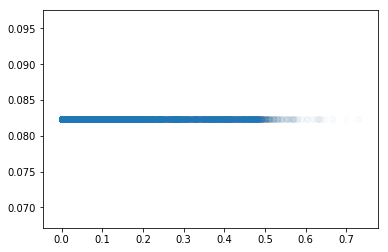

In [95]:
fig, ax = plt.subplots()
ax.scatter(y_test_baseline, y_pred_baseline, alpha=0.01)

# Controversy Top Model

In [59]:
topic_df = pd.read_csv('topic_staging_better.csv', sep="|")

In [60]:
topic_df['bill_num_unique'] = topic_df['biennium'] + ' ' + topic_df['bill_num'].apply(str)

In [61]:
topic_df = topic_df.drop('biennium', axis=1)

In [142]:
controversy_topics_df = controversy_X.merge(topic_df, how='left', on='bill_num_unique')

In [143]:
controversy_topics_df = controversy_topics_df[controversy_topics_df['HORSE'].notnull()]

In [144]:
controversy_topics_df.columns[0:20]

Index(['bill_num_unique', 'voter_id', 'voting_agency', 'unique_id',
       'sponsor_agency', 'party', 'is_minority_party', 'is_secondary_sponsor',
       'primary_sponsor_party', 'rep_score', 'bill_length', 'congress_num',
       'num_sponsors', 'years_until_vote', 'controversy_score', 'Unnamed: 0',
       'bill_id', 'bill_num', 'PROPERTY', 'ABORTION'],
      dtype='object')

In [152]:
# Make X and y
X = controversy_topics_df.drop(['bill_num_unique', 'bill_id', 'controversy_score', 'unique_id', 'bill_text'], 
                             axis=1)

y = controversy_topics_df['controversy_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=709)

In [ ]:
# model = RandomForestRegressor(n_estimators=2000, max_depth=6, n_jobs=2, random_state=709)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)

model = GradientBoostingRegressor(loss='ls', learning_rate=0.05, n_estimators=2000, max_depth=8, random_state=709)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [186]:
mean_squared_error(y_test, y_pred)

0.012619644711071342

In [187]:
r2_score(y_test, y_pred)

0.3521501309890607

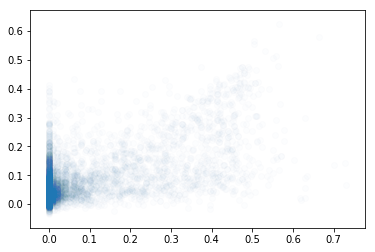

In [188]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, alpha=0.01)

In [120]:
features_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns)

In [121]:
features_importances_sorted = features_importances.sort_values(by=0, ascending=False)

In [122]:
features_importances_sorted[0:20]

,0
bill_length,0.083125
voter_id,0.076277
Unnamed: 0,0.074634
bill_num,0.072168
rep_score,0.068445
is_secondary_sponsor,0.063324
party,0.061007
voting_agency,0.057341
is_minority_party,0.056937
num_sponsors,0.025611


### NLP Playground

In [ ]:
# TRAIN
X_train = controversy_topics_df.drop(['bill_num_unique', 'bill_id', 'controversy_score'], 
                             axis=1)

y_train = controversy_topics_df['controversy_score']

# TEST
X_test = controversy_topics_df.drop(['bill_num_unique', 'bill_id', 'controversy_score'], 
                             axis=1)

y_test = controversy_topics_df['controversy_score']

In [147]:
# Merge bill_text to X_train and X_test
controversy_topics_df = controversy_topics_df.merge(bill_text_df_cleaned, how='left', on=['unique_id'])
controversy_topics_df = controversy_topics_df.drop(['index', 'htm_url', 'first_date_read'], axis=1)

In [148]:
controversy_topics_df

,bill_num_unique,voter_id,voting_agency,unique_id,sponsor_agency,party,is_minority_party,is_secondary_sponsor,primary_sponsor_party,rep_score,...,MEDALS,"PROFESSIONAL ENGINEERS AND LAND SURVEYORS, STATE BOARD OF REGISTRATION FOR",ROCKS AND MINERALS,LITTER,WASHINGTON STATE,CERTIFIED PROFESSIONAL GUARDIANSHIP BOARD,ELECTRICIANS,MUSICIANS,"PUBLIC GUARDIANSHIP, OFFICE",bill_text
0,1991-92 1001,248.894737,0.000000,2.000000,0.0,0.442105,0.442105,0.357895,0.0,0.764706,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,to nonpartisan elections; amending rcw 29.21....
1,1991-92 1003,252.833333,0.000000,5.000000,0.0,0.454545,0.454545,0.035354,0.0,0.250000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,to information on prescription drugs; and add...
2,1991-92 1003,252.833333,0.000000,5.000000,0.0,0.454545,0.454545,0.035354,0.0,0.250000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,to information on prescription drugs; and add...
3,1991-92 1008,254.904110,0.308219,13.000000,0.0,0.465753,0.472603,0.027397,0.0,0.250000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,to label information for over-the-counter med...
4,1991-92 1008,254.904110,0.308219,13.000000,0.0,0.465753,0.472603,0.027397,0.0,0.250000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,to label information for over-the-counter med...
5,1991-92 1009,246.921569,0.000000,14.000000,0.0,0.450980,0.450980,0.098039,0.0,0.727273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,to community councils in unincorporated areas...
6,1991-92 1012,246.921569,0.000000,20.000000,0.0,0.450980,0.450980,0.088235,0.0,0.400000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,to the loss of nets in the aquatic environmen...
7,1991-92 1013,250.254098,0.196721,24.000000,0.0,0.471311,0.463115,0.045082,1.0,0.714286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"to cities and towns."" current law states tha..."
8,1991-92 1015,254.379487,0.000000,27.000000,0.0,0.441026,0.441026,0.082051,0.0,0.454545,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,to local government service agreements; addin...
9,1991-92 1016,246.921569,0.000000,29.000000,0.0,0.450980,0.450980,0.421569,0.0,0.255814,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,to eligibility for a concealed weapon permit;...


In [ ]:
bills_train = sample_train['bill_text']
bills_test = sample_test['bill_text']
len(bills)

In [ ]:
tf = TfidfVectorizer(stop_words=stopwords_nltk, ngram_range=(1, 2), max_df=0.85, max_features=8000)

In [ ]:
fitted = tf.fit(bills)

In [ ]:
transformed_train = tf.transform(bills)

In [ ]:
transformed_test = tf.transform(bills_test)

In [ ]:
def tfidf_transformed_to_dataframe(transformed):
    tfidf_cols = transformed.toarray()
    tfidf_names = fitted.get_feature_names()
    tfidf_df = pd.DataFrame(tfidf_cols, columns=tfidf_names)

    return tfidf_df

In [ ]:
tfidf_train_df = tfidf_transformed_to_dataframe(transformed_train)
X_train = X_train.reset_index().drop('index', axis=1)
X_train = pd.concat([X_train, tfidf_train_df], axis=1)

In [ ]:
tfidf_test_df =  tfidf_transformed_to_dataframe(transformed_test)
X_test = X_test.reset_index().drop('index', axis=1)
X_test = pd.concat([X_test, tfidf_test_df], axis=1)

In [ ]:
X_train.head()

In [ ]:
model = RandomForestClassifier(n_estimators=5000, max_depth=7, n_jobs=2, random_state=709)
model.fit(X_train, y_train)
y_pred = (model.predict_proba(X_test))[:, 1]

In [ ]:
log_loss(y_test, y_pred)

In [ ]:
y_pred.min()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred, y_test, alpha=0.01)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [ ]:
roc_auc = roc_auc_score(y_test, y_pred)
roc_auc

In [ ]:
fig, ax = plt.subplots()
plt.plot(fpr, tpr, color='darkorange', label= f'ROC curve (area = {round(roc_auc, 3)})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC rep and loyalty scores 2015-16')
plt.legend(loc="lower right")
plt.show()

In [ ]:
features_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns)

In [ ]:
X_train.columns

In [ ]:
features_importances_sorted = features_importances.sort_values(by=0, ascending=False)

In [ ]:
features_importances_sorted